In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [13]:
## INITIALIZES VALUE TO USE IN SOLVING RADIATIVE ENERGY BALANCE MODEL

# MODEL PARAMETERS
SIGMA_B = 5.6696*10**(-8) # Stefan-Boltzmann constant [W/m^2K^4]
S0 = 1368 # solar constant [W/m^2]
RE = 6371*10**3 # radius of Earth [m]
AE = np.pi*RE**2 # surface area of Earth [m^2]
EPS = 1 # total emissivity of Earth (= 1 -> ideal black body)
TAU = 0.63 # atmospheric transmissivity
ALPHA_SKY = 0.2 # atmospheric albedo
ALPHA_LS = 0.4 # land surface albedo
ALPHA_OS = 0.1 # ocean surface albedo
ALPHA_ICE = 0.6 # ice albedo
RHO_LS = 2500 # density of land surface [kg/m^3]
RHO_OW = 1028 # density of ocean water [kg/m^3]
RHO_ICE = 900 # density of ice [kg/m^3]
Z_S = 1 # thermal scale depth for land [m]
Z_W = 70 # thermal scale depth for ocean [m]
Z_ICE = 1 # thermal scale depth for ice [m]
C_S = 790 # specific heat capacity for land [J*kg/K]
C_W = 4187 # specific heat capacity for water [J*kg/K]
C_I = 2060 # specific heat capacity for ice [J*kg/K]
SA_earth=5010072*10**(14) # surface area of the earth

# ZONE PROPERTIES
# 1
a1 = 0.067
A1 = a1*SA_earth
gamma_1 = 0.1076
# 2
a2 = 0.183
A2=a2*SA_earth
gamma_2 = 0.2277
# 3
a3 = 0.25
A3=a3*SA_earth
gamma_3 = 0.3045
# 4
a4 = 0.25
A4=a4*SA_earth
gamma_4 = 0.3045
# 5
a5 = 0.183
A5=a5*SA_earth
gamma_5 = 0.2277
# 6
a6 = 0.067
A6=a6*SA_earth
gamma_6 = 0.1076

# INTRA-ZONAL EXCHANGES
# boundary 12 (60deg S)
L12 = 2.0015*10**7 # boundary length [m]
k12 = 1*10**7 # thermal exchange coefficient [W/mK]
# boundary 23 (30deg S)
L23 = 3.4667*10**7
k23 = 1*10**7
# boundary 34 (0deg)
L34 = 4.003*10**7
k34 = 1*10**7
# boundary 45
L45 = 3.4667*10**7
k45 = 5*10**7
# boundary 56
L56 = 2.0015*10**7
k56 = 1*10**7

In [14]:
def calc_ave_values(land, ocean, ice):
    '''Receives proportion of land, ocean, and ice area on the surface of the zone.
    Returns the zonally averaged density (ave_rho), specific heat capacity (ave_c), and albedo (ave_alpha).'''
    ave_rho = (land * RHO_LS) + (ocean * RHO_OW) + (ice * RHO_ICE)
    ave_c = (land * C_S) + (ocean * C_W) + (ice * C_I)
    ave_alpha = (land * ALPHA_LS) + (ocean * ALPHA_OS) + (ice * ALPHA_ICE)
    ave_zed = (land * Z_S) + (ocean * Z_W) + (ice * Z_ICE)
    return ave_rho, ave_c, ave_alpha, ave_zed

In [15]:
# Define proportion of land, ocean, and ice cover on the zones.
land = np.array([0.1, 0.2, 0.3, 0.3, 0.1, 0.05])
ocean = np.array([0.6, 0.7, 0.7, 0.7, 0.8, 0.6])
ice = np.array([0.3, 0.1, 0.0, 0.0, 0.1, 0.35])

# Calculate zonally averaged density, specific heat capacity, and albedo.
rho = np.zeros(6)
c = np.zeros(6)
alpha = np.zeros(6)
Zed = np.zeros(6)
for i in range(6):
    rho[i], c[i], alpha[i], Zed[i] = calc_ave_values(land[i],ocean[i],ice[i])

In [16]:
def equations(t, T):
    dT1_dt = (1/(rho[0]*c[0]*Zed[0]))*((gamma_1*(1-ALPHA_SKY)*(1-alpha[0]))*S0 - TAU*SIGMA_B*(T[0]**4)) + (((L12*k12)*(T[1] - T[0])) / (A1*rho[0]*c[0]*Zed[0]))
    dT2_dt = (1/(rho[1]*c[1]*Zed[1]))*((gamma_2*(1-ALPHA_SKY)*(1-alpha[1]))*S0 - TAU*SIGMA_B*(T[1]**4)) + (((L23*k23*(T[2] - T[1]))-(L12*k12*(T[1] - T[0])))/(A2*rho[1]*c[1]*Zed[1]))
    dT3_dt = (1/(rho[2]*c[2]*Zed[2]))*((gamma_3*(1-ALPHA_SKY)*(1-alpha[2]))*S0 - TAU*SIGMA_B*(T[2]**4)) + (((L34*k34*(T[3] - T[2]))-(L23*k23*(T[2] - T[1])))/(A3*rho[2]*c[2]*Zed[2]))
    dT4_dt = (1/(rho[3]*c[3]*Zed[3]))*((gamma_4*(1-ALPHA_SKY)*(1-alpha[3]))*S0 - TAU*SIGMA_B*(T[3]**4)) + (((L45*k45*(T[4] - T[3]))-(L34*k34*(T[3] - T[2])))/(A4*rho[3]*c[3]*Zed[3]))
    dT5_dt = (1/(rho[4]*c[4]*Zed[4]))*((gamma_5*(1-ALPHA_SKY)*(1-alpha[4]))*S0 - TAU*SIGMA_B*(T[4]**4)) + (((L56*k56*(T[5] - T[4]))-(L45*k45*(T[4] - T[3])))/(A5*rho[4]*c[4]*Zed[4]))
    dT6_dt = (1/(rho[5]*c[5]*Zed[5]))*((gamma_6*(1-ALPHA_SKY)*(1-alpha[5]))*S0 - TAU*SIGMA_B*(T[5]**4)) - (((L56*k56)*(T[5] - T[4])) / (A6*rho[5]*c[5]*Zed[5]))
    return np.array([dT1_dt, dT2_dt, dT3_dt, dT4_dt, dT5_dt, dT6_dt])



In [24]:
init_temps = np.zeros(6)
init_temps[0] = 223.15
init_temps[1] = 273.15
init_temps[2] = 293.15
init_temps[3] = 293.15
init_temps[4] = 273.15
init_temps[5] = 223.15

In [27]:
this_method = 'DOP853'

# Define maximum allowable time step for solve_ivp.
max_dt = 1

# Assign the results of solve_ivp to the variable 'sol'
sol = solve_ivp(equations, [0,1000000000], init_temps, method=this_method) #, max_step=max_dt)

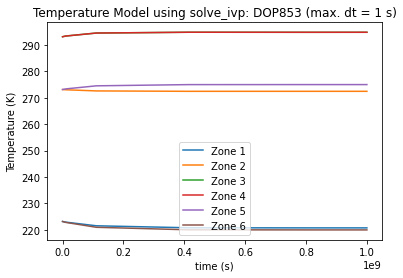

In [28]:
# Plot
plt.plot(sol.t, sol.y[0], label = 'Zone 1')
plt.plot(sol.t, sol.y[1], label = 'Zone 2')
plt.plot(sol.t, sol.y[2], label = 'Zone 3')
plt.plot(sol.t, sol.y[3], label = 'Zone 4')
plt.plot(sol.t, sol.y[4], label = 'Zone 5')
plt.plot(sol.t, sol.y[5], label = 'Zone 6')
plt.xlabel('time (s)')
plt.ylabel('Temperature (K)')
plt.title(f'Temperature Model using solve_ivp: {this_method} (max. dt = {max_dt} s)')
plt.legend()
plt.show()